# Restricted Boltzmann Machines for Recommender Systems

## Introduction
It's been in use since 2007, long before AI had its big resurgence, but it's still a commonly cited paper and a technique that's still in use today.
A few years ago, Netflix confirmed they were still using RBM's as part of their recommender system that's in production. Let's learn how it works.
First of all, if you're serious about using RBM's for recommendations, I recommend tracking down this [paper](https://www.cs.toronto.edu/~rsalakhu/papers/rbmcf.pdf) so you can study it later once you understand the general concepts. It's from a team from the University of Toronto and was published in the proceedings of the 24th International Conference on Machine Learning in 2007.

### Restricted Boltzmann Machines (RBMs)
RBM's are really one of the simplest neural networks. It's just two layers, a visible layer and a hidden layer. We train it by feeding our training data into the visible layer in a forward pass and training weights and biases between them during back propagation. An activation function such as ReLU is used to produce the output from each hidden neuron. 
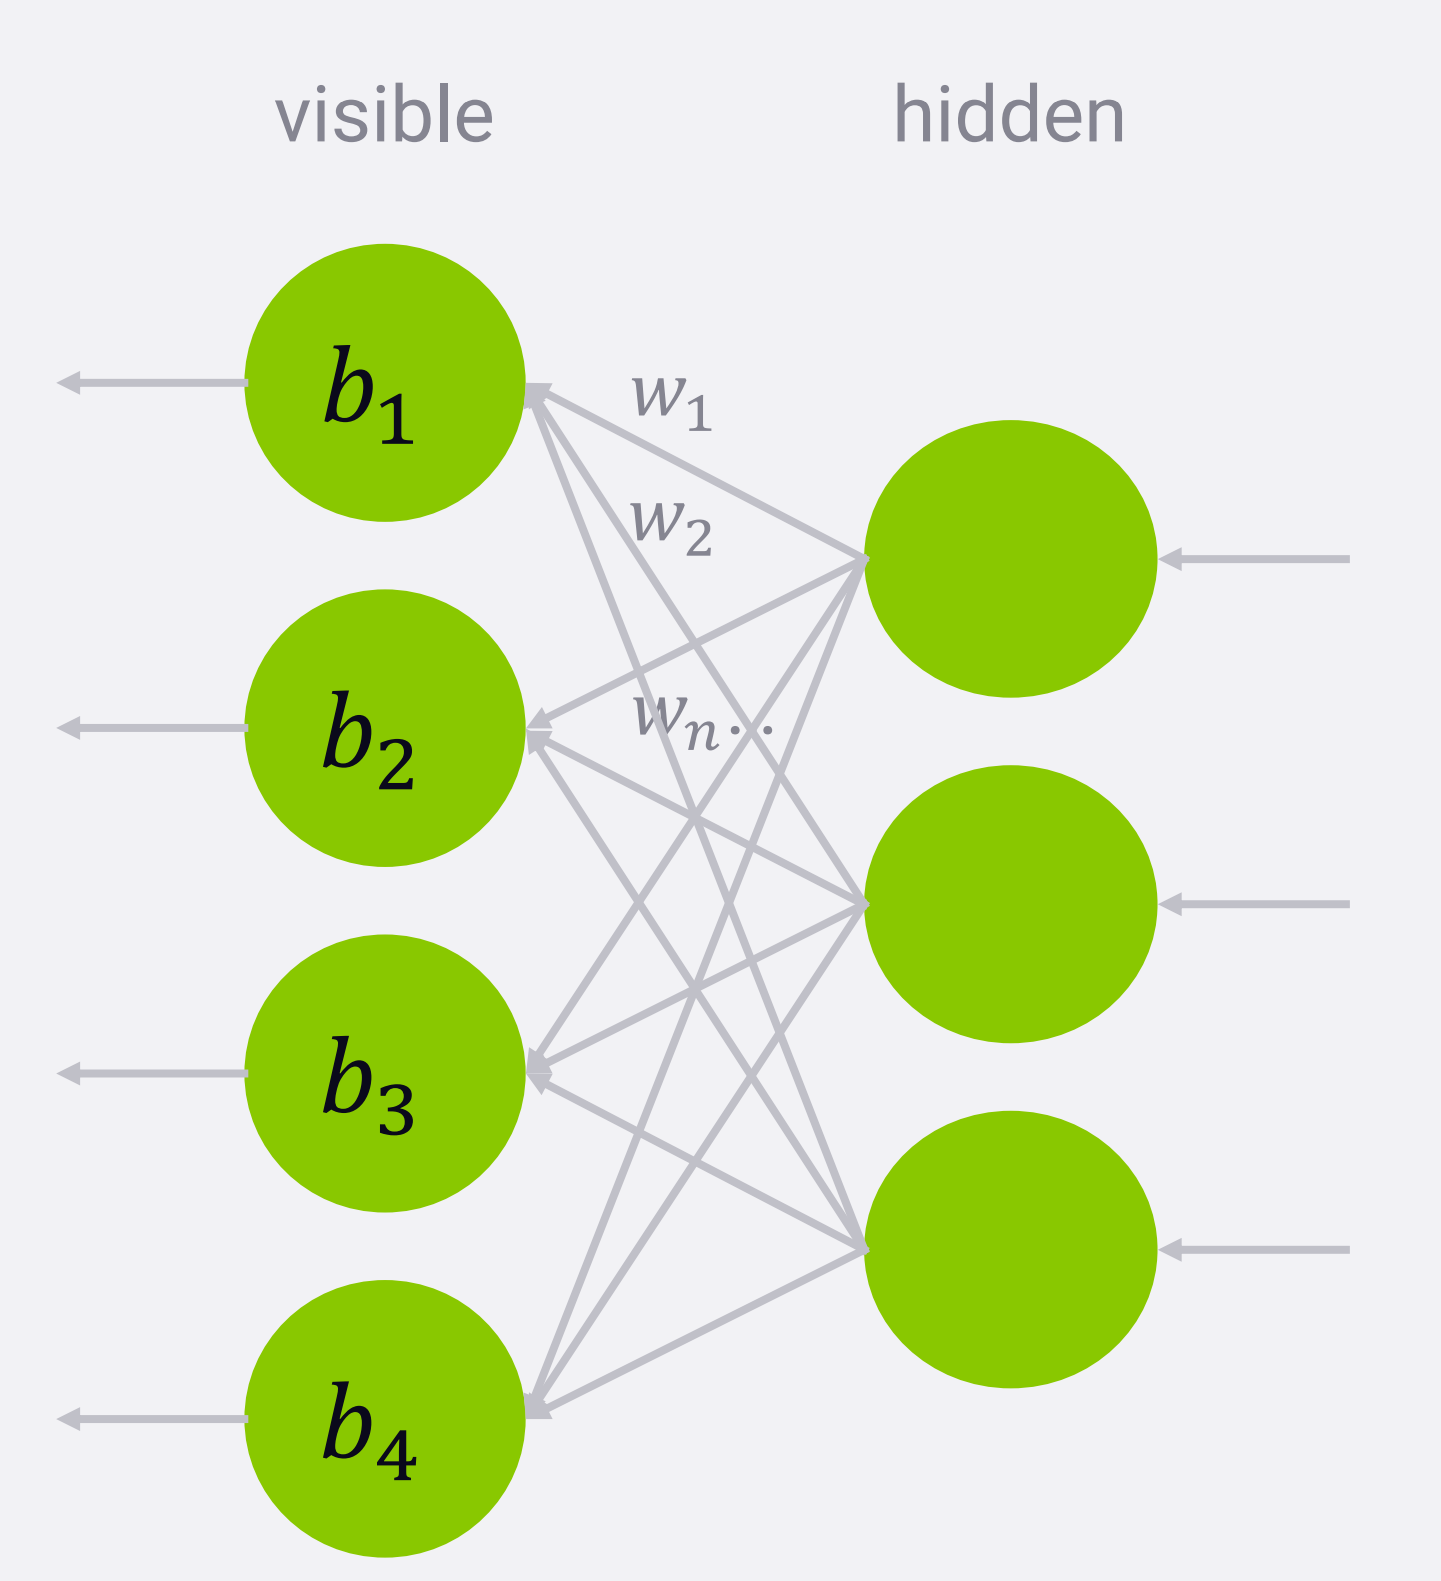

Why are they called Restricted Boltzmann Machines? Well they are restricted because neurons in the same layer can't communicate with each other directly. There are only connections between the two different layers. That's just what you do these days with modern neural networks, but that restriction didn't exist with earlier Boltzmann Machines back when AI was still kind of floundering as a field. And RBM's weren't invented by a guy named Boltzmann. The name refers to the Boltzmann distribution function they use for their sampling function. RBM's are actually credited to Geoffrey Hinton, who was a professor at Carnegie Mellon University at the time. The idea actually dates back to 1985. So RBM's get trained by doing a forward pass, which we just described, and then a backward pass where the inputs get reconstructed. We do this iteratively over many epochs just like when we train a deep neural network until it converges on a set of weights and biases that minimizes the error.
Let's take a closer look at that backward pass.
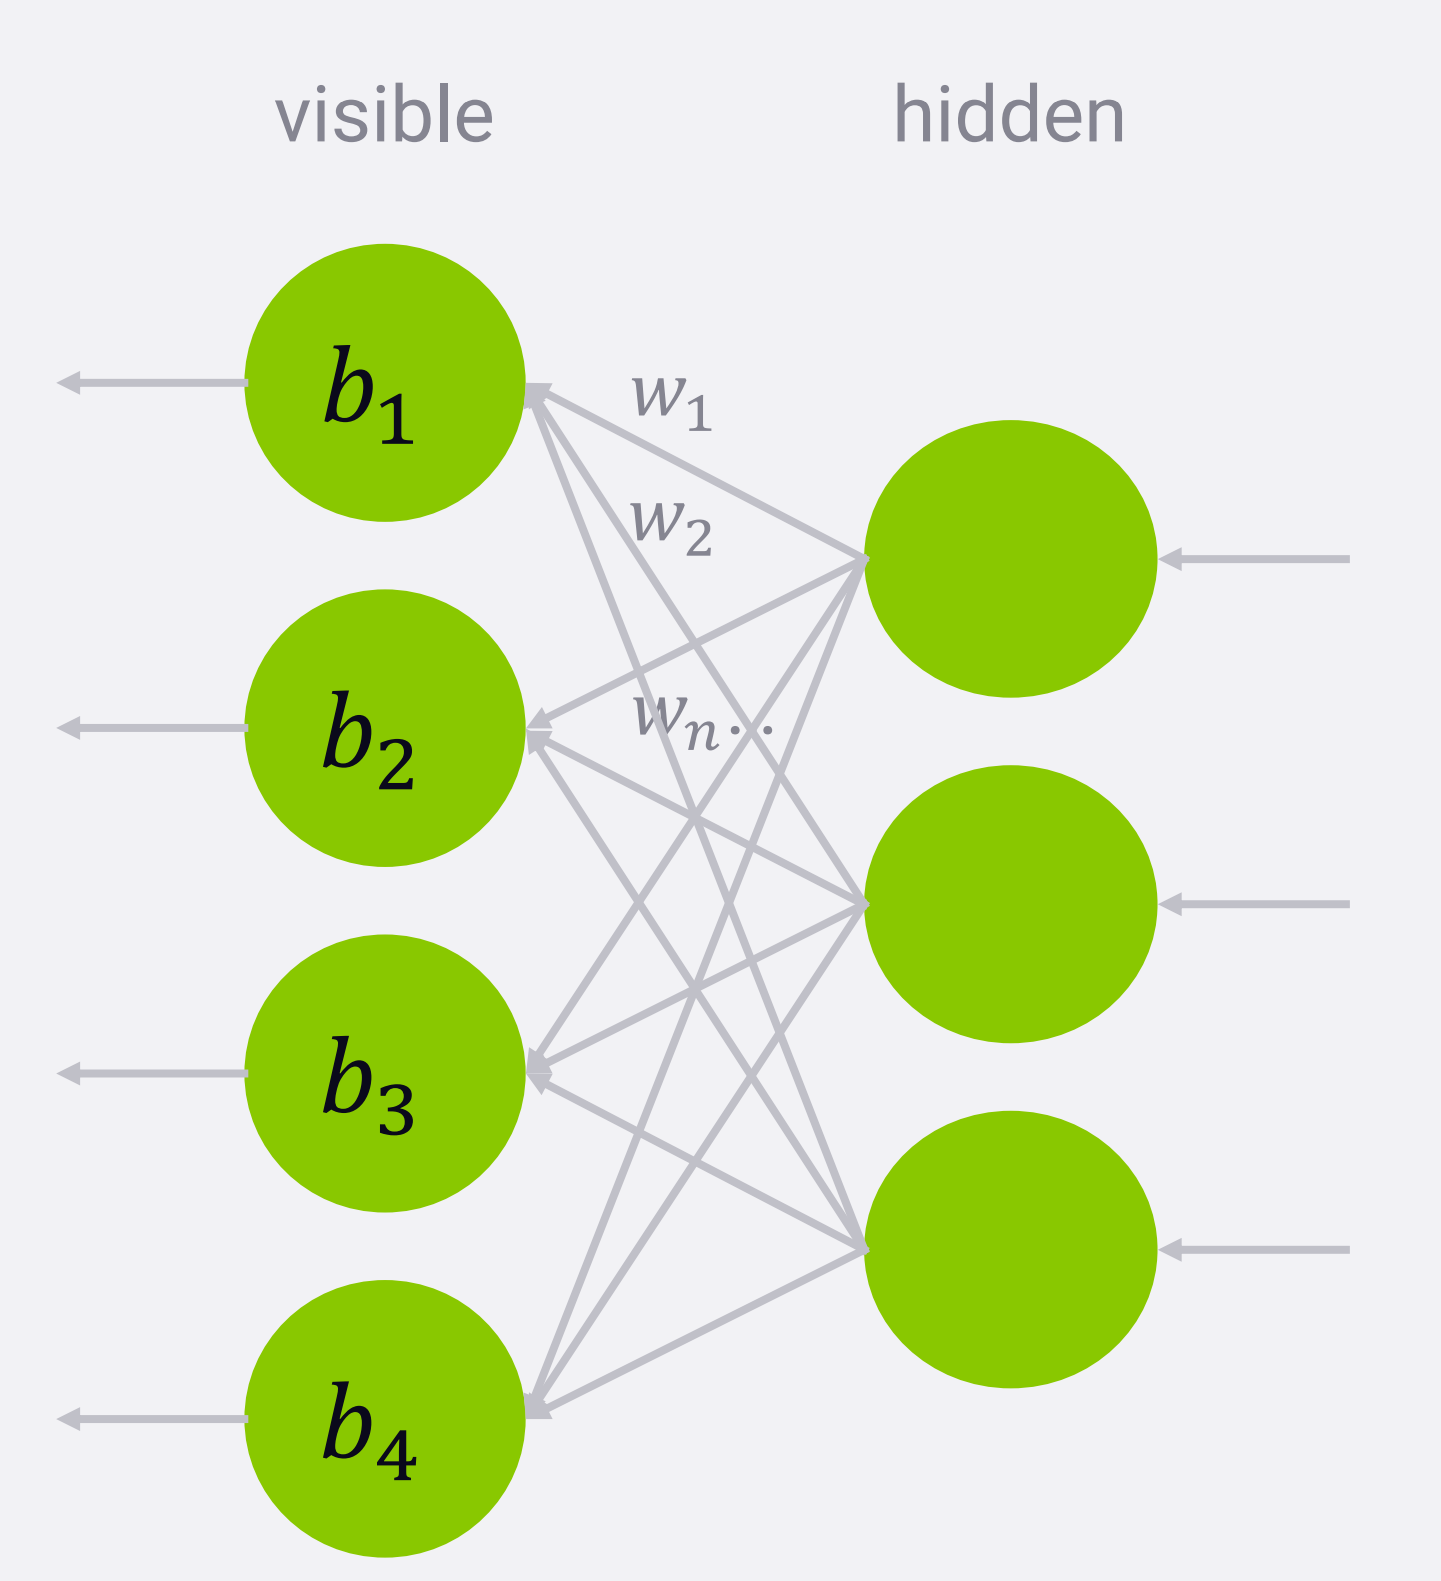

During the backward pass we are trying to reconstruct the original input by feeding back the output of the forward pass back through the hidden layer and seeing what values we end up with out of the visible layer. Since those weights are initially random, there can be a big difference between the inputs we started with and the ones we reconstruct. In the process we end up with another set of bias terms, this time on the visible layer. So we share weights between both the forward and backward passes, but we have two sets of biases. The hidden bias that's used in the forward pass and the visible bias that's used in this backward pass. We can then measure the error we end up with and use that information to adjust the weights a little bit during the next iteration to try and minimize that error.

You can also construct multi layer RBM's that are akin to modern deep learning architectures. The main difference is that we read the output of an RBM on the lower level during a backward pass as opposed to just taking the outputs on the other side like we would with a modern neural network.

So this all works well when you have a complete set of training data, for example applying an RBM to the same MNIST handwriting recognition problem we looked at in this [notebook](https://www.kaggle.com/alirezanematolahy/handwriting-recognition-with-keras) is a straightforward thing to do. 

When you applying RBMs or neural networks in general to recommender systems though, things get wierd. The problem is that we have sparse training data, very sparse in most cases. How do you train a neural network when most of your input nodes have no data to work with?

# RBMs for recommender systems

Adapting a RBM for say recommender movies giving 5 star ratings data requires a few twists to the generic RBM architecture we just described.
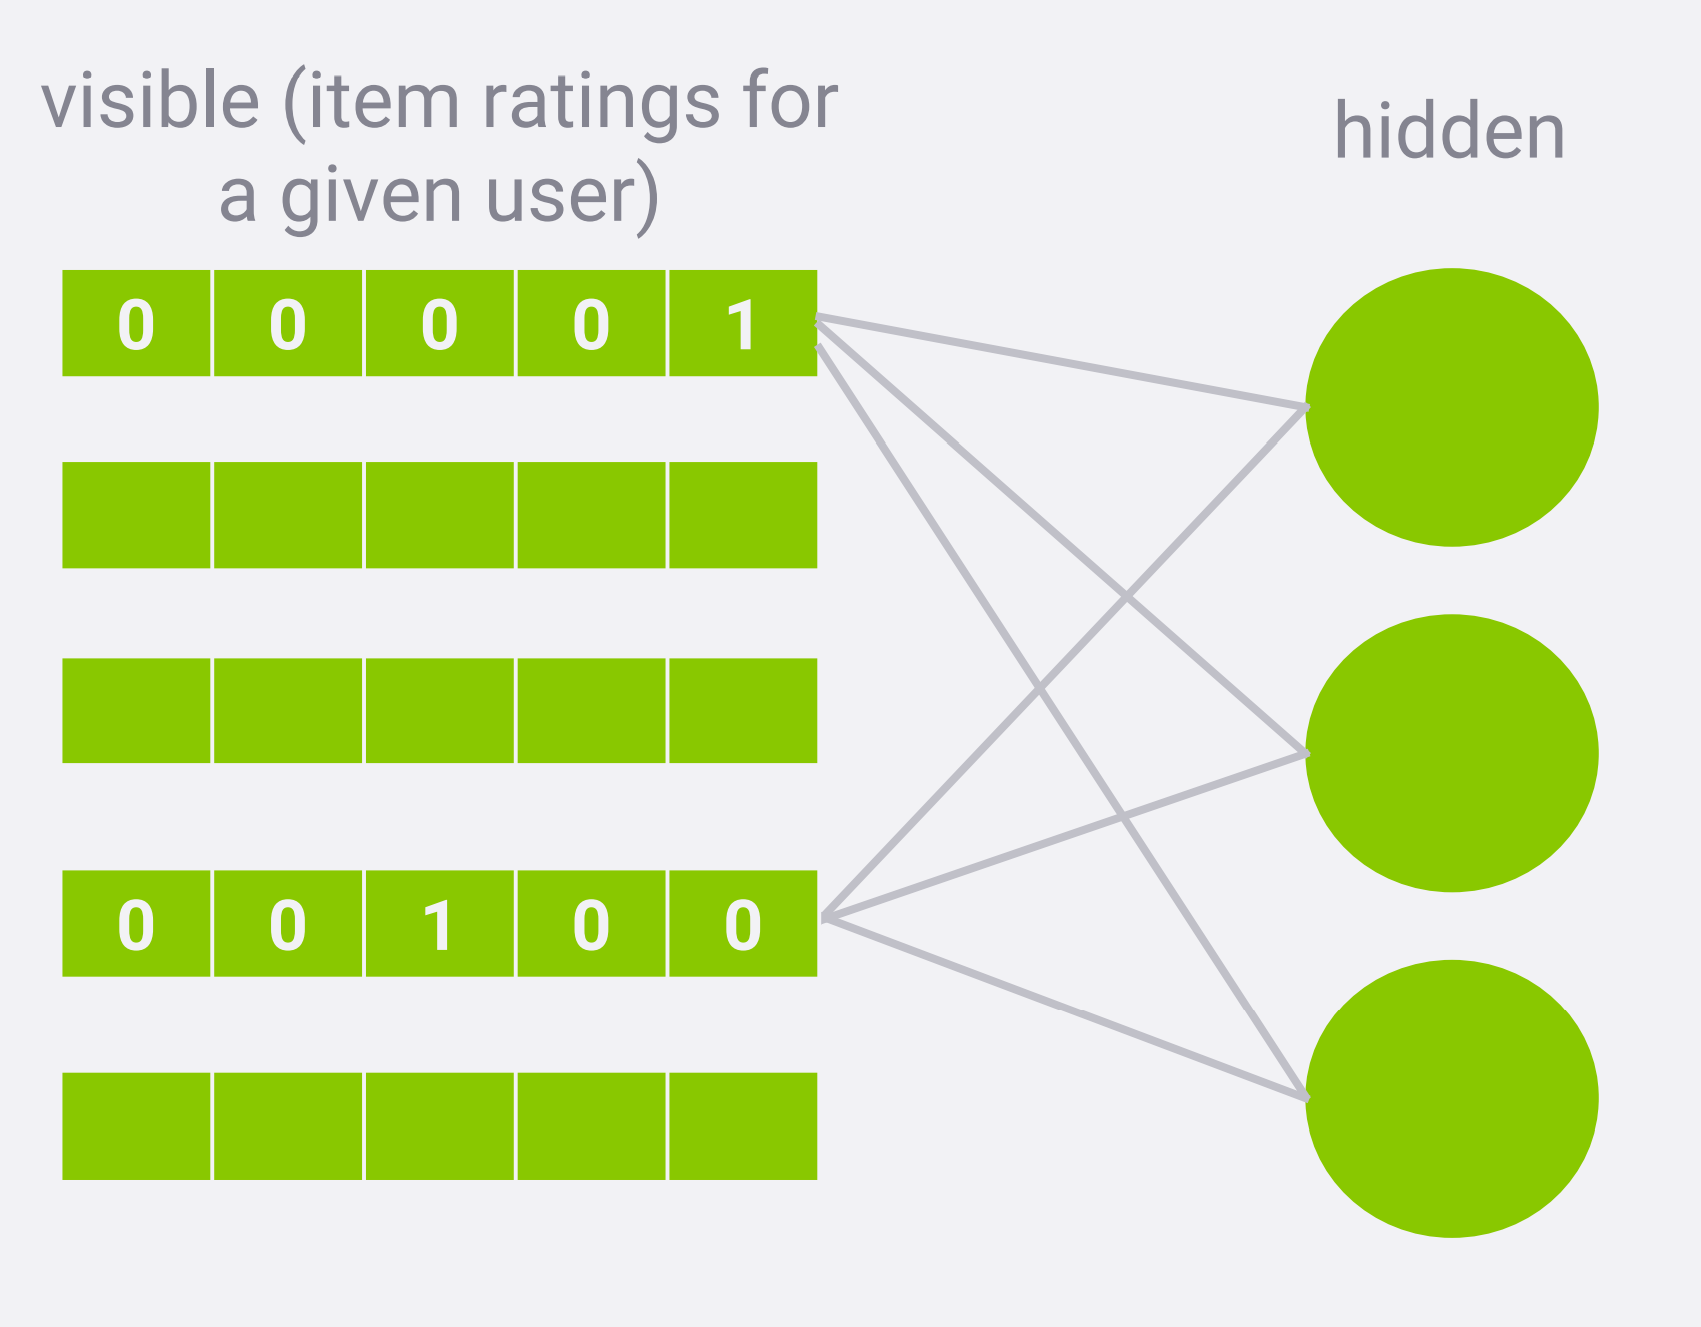

Let's take a step back and think about what we're doing here The general idea is to use each individual user in our training data as a set of inputs into our RBM to help train it. So we process each user as part of a batch during training, looking at their ratings for every movie they rated. So our visible nodes represent ratings for a given user on every movie, and we're trying to learn weights and biases that let us reconstruct ratings for user movie pairs we don't know yet. 

First of all our visible units aren't just simple nodes taking in a single input. Ratings are really categorical data. So we actually want to treat each individual rating as five nodes, one for each possible rating value. So let's say the first rating we have on our training data is the five star rating. That would be represented as four nodes with the value of zero and one with the value of one as represented here. Then we have a couple of ratings that are missing for user item pairs that are unknown and need to be predicted, then we have a three star rating represented like this with a one in the third slot. When we're done training the RBM, we'll have a set of weights and biases that should allow us to reconstruct ratings for any user. So to use it to predict ratings for a new user, we just run it once again using the known ratings of the user we're interested in. We run those through in the forward pass then back again in the backward pass and end up with reconstructed rating values for that user. We can then run soft max on each group of five rating values to translate the output back into a five star rating for every item. But again, the big problem is that the data we have is sparse. If we are training an RBM on every possible combination of users and movies, most of that data will be missing, because most movies have not been rated at all by a specific user. We want to predict user ratings for every movie, though so we need to leave space for all of them. That means if we have n movies, we end up with n times five visible nodes and for any given user, most of them are undefined and empty. 
We deal with this by excluding any missing ratings from processing while we're training the RBM. This is kind of a tricky thing to do, because most frameworks built for deep learning such as TensorFlow assume you want to process everything in parallel all the time. 
Sparse data isn't something they were really built for originally, but there are ways to trick it into doing what we want. But notice that we've only drawn lines between visible units that actually have known ratings data in them and the hidden layer. 
So as we're training our RBM with a given user's known ratings, we only attempt to learn the weights and biases used for the movies that user actually rated. As we iterate through training on all of the other users, we fill in the other weights and biases as we go.

For the sake of completeness I should point out that TensorFlow actually does have a sparse tensor these days you can use and there are other frameworks, such as [Amazon's Destiny system](https://aws.amazon.com/blogs/big-data/generating-recommendations-at-amazon-scale-with-apache-spark-and-amazon-dsstne/) that are designed to construct more typical deep neural networks with sparse data.
RBM's will probably become a thing of the past now that we can treat sparse data in the same manner as complete data with modern neural networks and we will examine that in more depth in this notebook.
The other twist is how to best train an RBM that contains huge amounts of sparse data. Gradient descent needs a very efficient expectation function to optimize on and for recommender systems this function is called contrastive divergence. At least that's the function the paper on the topic uses successfully. The math behind it gets a bit complicated, but the basic idea is that it samples probability distributions during training, using something called a Gibbs sampler. We only train it on the ratings that actually exist, but reuse the resulting weights and biases across other users to fill in the missing ratings we want to predict. So let's look at some code that actually implements an RBM on our movie lens data and play around with it.

In [ ]:
"""
this is what implements the restricted boltzmann machine it self with a twist
we talk about that specific recommender systems such as using contrastive divergence
it may look a little complex and it is, I mean we're basicly making a brain here
that can keep track of hundreds of different people and guess what movies they might like 
given a hundred thousand ratings.
"""
import numpy as np
import tensorflow as tf

class RBMs(object):
    
    def __init__(self, visibleDimensions, epochs=20, hiddenDimensions=50, ratingValues=10, learningRate=0.001, batchSize=100):
        """
        our init function takes several different parameters, hyperparameteres if you will,
        that give us control over how the learning RMB works.
        It turns out these values are pretty important for how well it all works.
        Visible dimensions is kind of non-negotiable. It's the product of the number of movies 
        and how many distinct rating values you have, as we discussed earlier.
        In other words, a pretty big number. Epochs is how many iterations you're going to take 
        on the forward and backward passes while we try to minimize the error between
        our actual rating values and the reconstructed predicted values.
        That is, how many times will we train our RBM across all of the users in our training data
        and hopes that it will converges weights and biases we can use for future predictions.
        HiddenDimentions is the munber of hidden neurons in the system which can be surprisingly small,
        comparing to number of visible neurons.
        Next we have the number of distinc rating values since our data actualy contains half star
        rating values, we have 10 possible rating values and not just 5.
        We then have the learning rate which controls how quickly we attemp to converge on each iteration
        this need to be balanced so you find the right values in reasonable number of steps without skipping the best
        results in the process.
        And finally we have the batch size which control how many users we process at a time while training.
        We store all of this within the RBM objects so we can use them in other functions. 
        """
        self.visibleDimensions = visibleDimensions
        self.epochs = epochs
        self.hiddenDimensions = hiddenDimensions
        self.ratingValues = ratingValues
        self.learningRate = learningRate
        self.batchSize = batchSize
        
                
    def Train(self, X):
        """
        The train function is what we call when we want to create a RBM with weights and biases that will
        allow us to reconstruct any users rating for any item.
        It takes in an array called X which is a 2D array that has a row of rating values for every user.
        Those rating values are flatten binary values one for each possible rating type like we showed in introduction.
        So this input array contains a row for every user and every row contains binary data for the number of movies,
        times to 10 possible rating values we have. We're using Tensorflow so we start by reseting everything
        in case you try to train the same RBM more than once.
        Next we call MakeGraph function which we'll look at soon it contains the RBM model itself.
        We then Create a Tensorflow session to run the RBM within, iterate over every epoch,
        shuffling the users everytime, and divided into baches of users that can run together as we converge
        better weight and biases values both hidden biases and visible biases.
        """
        for epoch in range(self.epochs):
            np.random.shuffle(X)
            
            trX = np.array(X)
            for i in range(0, trX.shape[0], self.batchSize):
                epochX = trX[i:i+self.batchSize]
                self.MakeGraph(epochX)

            print("Trained epoch ", epoch)


    def GetRecommendations(self, inputUser):
        """
        GetRecommendations function is how we get preditcions for a given user using a RBM
        that's already been trained and has a set of optimized weights and biases in place.
        The input here is an array of every rating type for every movie for one user, where that users known
        ratings is filled in.
        We define a simple RBM here for this purpose with just a couple of lines.
        Our forward pass creates a hidden layer by multiplying the visible layer X with our weights and adding
        in the bias terms.
        We then reconstruct visible layer by multiplying the hissen layer by the same weights and adding
        in the visible bias terms we computing during training, that's the backward pass.
        What's left are the reconstructed rating values for every movie which pass back for further processing.
        """
        feed = self.MakeHidden(inputUser)
        rec = self.MakeVisible(feed)
        return rec[0]       

    def MakeGraph(self, inputUser):
        """
        MakeGraph function, the base function in all of this!
        First we set a cosisting random seed, so we consisting results from the run.
        Next we need set up placeholders in tensorflow for nodes, weight and biases that make up our RBM.
        We start with X which is our visible nodes remeber we have one for every possible rating value
        for every possible movie that product contains our visible dimentions property.
        Even though we'll automatically be binary data the RBM will place floating point values in there in 
        backward pass so we need to convert back to binary, so the type is float32. 
        Next we set up out weights and this must be initialized random data but it can't be just any random data.
        in this case -4.0 times to squared 6 over the root of the total number of nodes is a right thing to do.
        and that gives us the magnitude of the positive and negative extence of the initial random weights.
        Next we set aside the bias terms.Remember in a RBM  we do both forward and backward pass and we end up
        with bias terms on both hidden and visible layers as a result. so we have both hidden bias tensor 
        associated with hidden nodes and a visible bias tensor associated with the visible nodes and we
        initialize them all to zero. 
        Notice we've made X, weights, hidden bias and visible bias all members of the RBM class itself,
        because these are the parts of a trained RBM we need to keep around even after makegraph is called.
        We'll need those to reconstruct the RBM for making predictions later. 
        Next we need to set up the specifics of the forward and backward passes and it's both what's needed 
        to allow system to converge using contrastive divergence while it is learning.
        hProb0 is a new tensor that represents the values of the hidden nodes at the end of the forward pass.
        we multiply the visible nodes and X which contain training data from a given user by our weights which
        initially are random but get better with each batch retrain with. Then we add in the hidden bias terms,
        apply a sigmoid activation function and we have got our hidden layer output of forward pass.
        Before contrastive divergence we need to perform Gibbs sampling of those hidden probabilities
        coming out of the hidden nodes. We have a new tensor, hSample, which is applying to ReLU
        activatin function to the sign of the hidden probabilities with a random value subtractive from them
        This has the effect of selecting a random sample of the complete set of hidden node values.
        So the weight for that sampled forward pass is what we actually store in a tensor where naming forward
        and computing those weights is what's makes it all happen.
        In backward pass where we reconstruct the visible layer by running the RBM in reverse from
        the hidden nodes outputs.
        The tensor V takes our sample output from the forward pass which it's name is hSample, multiplying by
        weights and adds in the visible bias terms.
        
        We have to deal with missing ratings and translate this scores to get reconstructed in the binary values,
        define actual rating classifications.
        
        First Let's deal with missing ratings
        We know that we dont want to predect anything at all but training for movies users didn't rate since
        we don't have a rating to compare predictions against. This is the sparse data problem we described
        earlier. So to handle that we'll create a mask from the original ratings from the user that exist in the X tensor.
        We start by making sure of that everything in our mask is either zero or one by applying the sign function
        to it then we'll reshape our mask tensor in the 3 Dimentions one for each user in our batch, one for each movie
        and one for each set of 10 values that represent of a single rating.
        So at this point each indivisual set of 0 to 9 rating values might contain all zeros which will indicates
        a missing rating that does not exist in training data at all or there might be single value of one in it
        which would indicate an actual rating value. To figure out which it is, we'll apply the reduce_max function on line 79.
        It finds the maximum value in each rating. So, missing ratings end up getting reduced to the value zero
        and actual ratings get reduced to the value one. So, we have each set of 10 binary rating values organized
        together for each movie.Then we multiply the reconstructed visible layer by our mask, which has the effect
        of leaving reconstructed data for ratings we actually have data for and leaving all the missing ratings as zero.
        We then apply the soft_max function to the results, which will only do anything meaningful as soft_max units,
        but it does the job. In some ways, it might have been easier to code this algorithm up without using TensorFlow,
        but then, we couldn't really use our GPU to do it quickly. Alright, finally, we tie everything together
        and tell TensorFlow what we want it to do in every batch. We run the forward and backward passes and
        update the weights. Then we updates the hidden bias terms, trying to minimize error between the hidden node outputs
        from the original data and from the reconstructed data and then update the visible bias terms, 
        trying to minimize error between the original training data and the reconstructed visible data.
        
        Then, we stick it all inside self.update, which is ultimately what gets run when we call our train function.
    
        """

        # Initialize weights randomly
        maxWeight = -4.0 * np.sqrt(6.0 / (self.hiddenDimensions + self.visibleDimensions))
        self.weights = tf.Variable(tf.random.uniform([self.visibleDimensions, self.hiddenDimensions], minval=-maxWeight, maxval=maxWeight), tf.float32, name="weights")
        
        self.hiddenBias = tf.Variable(tf.zeros([self.hiddenDimensions], tf.float32, name="hiddenBias"))
        self.visibleBias = tf.Variable(tf.zeros([self.visibleDimensions], tf.float32, name="visibleBias"))
        
        # Perform Gibbs Sampling for Contrastive Divergence, per the paper we assume k=1 instead of iterating over the 
        # forward pass multiple times since it seems to work just fine
        
        # Forward pass
        # Sample hidden layer given visible...
        # Get tensor of hidden probabilities
        hProb0 = tf.nn.sigmoid(tf.matmul(inputUser, self.weights) + self.hiddenBias)
        # Sample from all of the distributions
        hSample = tf.nn.relu(tf.sign(hProb0 - tf.random.uniform(tf.shape(hProb0))))
        # Stitch it together
        forward = tf.matmul(tf.transpose(inputUser), hSample)
        
        # Backward pass
        # Reconstruct visible layer given hidden layer sample
        v = tf.matmul(hSample, tf.transpose(self.weights)) + self.visibleBias
        
        # Build up our mask for missing ratings
        vMask = tf.sign(inputUser) # Make sure everything is 0 or 1
        vMask3D = tf.reshape(vMask, [tf.shape(v)[0], -1, self.ratingValues]) # Reshape into arrays of individual ratings
        vMask3D = tf.reduce_max(vMask3D, axis=[2], keepdims=True) # Use reduce_max to either give us 1 for ratings that exist, and 0 for missing ratings
        
        # Extract rating vectors for each individual set of 10 rating binary values
        v = tf.reshape(v, [tf.shape(v)[0], -1, self.ratingValues])
        vProb = tf.nn.softmax(v * vMask3D) # Apply softmax activation function
        vProb = tf.reshape(vProb, [tf.shape(v)[0], -1]) # And shove them back into the flattened state. Reconstruction is done now.
        # Stitch it together to define the backward pass and updated hidden biases
        hProb1 = tf.nn.sigmoid(tf.matmul(vProb, self.weights) + self.hiddenBias)
        backward = tf.matmul(tf.transpose(vProb), hProb1)
    
        # Now define what each epoch will do...
        # Run the forward and backward passes, and update the weights
        weightUpdate = self.weights.assign_add(self.learningRate * (forward - backward))
        # Update hidden bias, minimizing the divergence in the hidden nodes
        hiddenBiasUpdate = self.hiddenBias.assign_add(self.learningRate * tf.reduce_mean(hProb0 - hProb1, 0))
        # Update the visible bias, minimizng divergence in the visible results
        visibleBiasUpdate = self.visibleBias.assign_add(self.learningRate * tf.reduce_mean(inputUser - vProb, 0))

        self.update = [weightUpdate, hiddenBiasUpdate, visibleBiasUpdate]
        
    def MakeHidden(self, inputUser):
        hidden = tf.nn.sigmoid(tf.matmul(inputUser, self.weights) + self.hiddenBias)
        self.MakeGraph(inputUser)
        return hidden
    
    def MakeVisible(self, feed):
        visible = tf.nn.sigmoid(tf.matmul(feed, tf.transpose(self.weights)) + self.visibleBias)
        #self.MakeGraph(feed)
        return visible


# RBM Algorithm :

In [ ]:
from surprise import AlgoBase
from surprise import PredictionImpossible
import numpy as np


class RBMAlgorithm(AlgoBase):

    def __init__(self, epochs=20, hiddenDim=100, learningRate=0.001, batchSize=100, sim_options={}):
        AlgoBase.__init__(self)
        self.epochs = epochs
        self.hiddenDim = hiddenDim
        self.learningRate = learningRate
        self.batchSize = batchSize

    def softmax(self, x):
        return np.exp(x) / np.sum(np.exp(x), axis=0)

    def fit(self, trainset):
        AlgoBase.fit(self, trainset)

        numUsers = trainset.n_users
        numItems = trainset.n_items

        trainingMatrix = np.zeros([numUsers, numItems, 10], dtype=np.float32)

        for (uid, iid, rating) in trainset.all_ratings():
            adjustedRating = int(float(rating)*2.0) - 1
            trainingMatrix[int(uid), int(iid), adjustedRating] = 1

        # Flatten to a 2D array, with nodes for each possible rating type on each possible item, for every user.
        trainingMatrix = np.reshape(trainingMatrix, [trainingMatrix.shape[0], -1])

        # Create an RBM with (num items * rating values) visible nodes
        rbm = RBMs(trainingMatrix.shape[1], hiddenDimensions=self.hiddenDim, learningRate=self.learningRate, batchSize=self.batchSize, epochs=self.epochs)
        rbm.Train(trainingMatrix)

        self.predictedRatings = np.zeros([numUsers, numItems], dtype=np.float32)
        for uiid in range(trainset.n_users):
            if (uiid % 50 == 0):
                print("Processing user ", uiid)
            recs = rbm.GetRecommendations([trainingMatrix[uiid]])
            recs = np.reshape(recs, [numItems, 10])

            for itemID, rec in enumerate(recs):
                # The obvious thing would be to just take the rating with the highest score:
                #rating = rec.argmax()
                # ... but this just leads to a huge multi-way tie for 5-star predictions.
                # The paper suggests performing normalization over K values to get probabilities
                # and take the expectation as your prediction, so we'll do that instead:
                normalized = self.softmax(rec)
                rating = np.average(np.arange(10), weights=normalized)
                self.predictedRatings[uiid, itemID] = (rating + 1) * 0.5

        return self


    def estimate(self, u, i):

        if not (self.trainset.knows_user(u) and self.trainset.knows_item(i)):
            raise PredictionImpossible('User and/or item is unkown.')

        rating = self.predictedRatings[u, i]

        if (rating < 0.001):
            raise PredictionImpossible('No valid prediction exists.')

        return rating

    


# Preparing data :

In [ ]:
import os
import csv
import sys
import re

from surprise import Dataset
from surprise import Reader

from collections import defaultdict

class MovieLens:

    movieID_to_name = {}
    name_to_movieID = {}
    ratingsPath = '/kaggle/input/movielens/ratings.csv'
    moviesPath = '/kaggle/input/movielens/movies.csv'
    def loadMovieLensLatestSmall(self):

        # Look for files relative to the directory we are running from
        os.chdir(os.path.dirname(sys.argv[0]))

        ratingsDataset = 0
        self.movieID_to_name = {}
        self.name_to_movieID = {}

        reader = Reader(line_format='user item rating timestamp', sep=',', skip_lines=1)

        ratingsDataset = Dataset.load_from_file(self.ratingsPath, reader=reader)

        with open(self.moviesPath, newline='', encoding='ISO-8859-1') as csvfile:
                movieReader = csv.reader(csvfile)
                next(movieReader)  #Skip header line
                for row in movieReader:
                    movieID = int(row[0])
                    movieName = row[1]
                    self.movieID_to_name[movieID] = movieName
                    self.name_to_movieID[movieName] = movieID

        return ratingsDataset

    def getUserRatings(self, user):
        userRatings = []
        hitUser = False
        with open(self.ratingsPath, newline='') as csvfile:
            ratingReader = csv.reader(csvfile)
            next(ratingReader)
            for row in ratingReader:
                userID = int(row[0])
                if (user == userID):
                    movieID = int(row[1])
                    rating = float(row[2])
                    userRatings.append((movieID, rating))
                    hitUser = True
                if (hitUser and (user != userID)):
                    break

        return userRatings

    def getPopularityRanks(self):
        ratings = defaultdict(int)
        rankings = defaultdict(int)
        with open(self.ratingsPath, newline='') as csvfile:
            ratingReader = csv.reader(csvfile)
            next(ratingReader)
            for row in ratingReader:
                movieID = int(row[1])
                ratings[movieID] += 1
        rank = 1
        for movieID, ratingCount in sorted(ratings.items(), key=lambda x: x[1], reverse=True):
            rankings[movieID] = rank
            rank += 1
        return rankings

    def getGenres(self):
        genres = defaultdict(list)
        genreIDs = {}
        maxGenreID = 0
        with open(self.moviesPath, newline='', encoding='ISO-8859-1') as csvfile:
            movieReader = csv.reader(csvfile)
            next(movieReader)  #Skip header line
            for row in movieReader:
                movieID = int(row[0])
                genreList = row[2].split('|')
                genreIDList = []
                for genre in genreList:
                    if genre in genreIDs:
                        genreID = genreIDs[genre]
                    else:
                        genreID = maxGenreID
                        genreIDs[genre] = genreID
                        maxGenreID += 1
                    genreIDList.append(genreID)
                genres[movieID] = genreIDList
        # Convert integer-encoded genre lists to bitfields that we can treat as vectors
        for (movieID, genreIDList) in genres.items():
            bitfield = [0] * maxGenreID
            for genreID in genreIDList:
                bitfield[genreID] = 1
            genres[movieID] = bitfield

        return genres

    def getYears(self):
        p = re.compile(r"(?:\((\d{4})\))?\s*$")
        years = defaultdict(int)
        with open(self.moviesPath, newline='', encoding='ISO-8859-1') as csvfile:
            movieReader = csv.reader(csvfile)
            next(movieReader)
            for row in movieReader:
                movieID = int(row[0])
                title = row[1]
                m = p.search(title)
                year = m.group(1)
                if year:
                    years[movieID] = int(year)
        return years

    def getMiseEnScene(self):
        mes = defaultdict(list)
        with open("LLVisualFeatures13K_Log.csv", newline='') as csvfile:
            mesReader = csv.reader(csvfile)
            next(mesReader)
            for row in mesReader:
                movieID = int(row[0])
                avgShotLength = float(row[1])
                meanColorVariance = float(row[2])
                stddevColorVariance = float(row[3])
                meanMotion = float(row[4])
                stddevMotion = float(row[5])
                meanLightingKey = float(row[6])
                numShots = float(row[7])
                mes[movieID] = [avgShotLength, meanColorVariance, stddevColorVariance,
                   meanMotion, stddevMotion, meanLightingKey, numShots]
        return mes

    def getMovieName(self, movieID):
        if movieID in self.movieID_to_name:
            return self.movieID_to_name[movieID]
        else:
            return ""

    def getMovieID(self, movieName):
        if movieName in self.name_to_movieID:
            return self.name_to_movieID[movieName]
        else:
            return 0


# Evaluation Data :

In [ ]:
from surprise.model_selection import train_test_split
from surprise.model_selection import LeaveOneOut
from surprise import KNNBaseline

class EvaluationData:

    def __init__(self, data, popularityRankings):

        self.rankings = popularityRankings

        #Build a full training set for evaluating overall properties
        self.fullTrainSet = data.build_full_trainset()
        self.fullAntiTestSet = self.fullTrainSet.build_anti_testset()

        #Build a 75/25 train/test split for measuring accuracy
        self.trainSet, self.testSet = train_test_split(data, test_size=.25, random_state=1)

        #Build a "leave one out" train/test split for evaluating top-N recommenders
        #And build an anti-test-set for building predictions
        LOOCV = LeaveOneOut(n_splits=1, random_state=1)
        for train, test in LOOCV.split(data):
            self.LOOCVTrain = train
            self.LOOCVTest = test

        self.LOOCVAntiTestSet = self.LOOCVTrain.build_anti_testset()

        #Compute similarty matrix between items so we can measure diversity
        sim_options = {'name': 'cosine', 'user_based': False}
        self.simsAlgo = KNNBaseline(sim_options=sim_options)
        self.simsAlgo.fit(self.fullTrainSet)

    def GetFullTrainSet(self):
        return self.fullTrainSet

    def GetFullAntiTestSet(self):
        return self.fullAntiTestSet

    def GetAntiTestSetForUser(self, testSubject):
        trainset = self.fullTrainSet
        fill = trainset.global_mean
        anti_testset = []
        u = trainset.to_inner_uid(str(testSubject))
        user_items = set([j for (j, _) in trainset.ur[u]])
        anti_testset += [(trainset.to_raw_uid(u), trainset.to_raw_iid(i), fill) for
                                 i in trainset.all_items() if
                                 i not in user_items]
        return anti_testset

    def GetTrainSet(self):
        return self.trainSet

    def GetTestSet(self):
        return self.testSet

    def GetLOOCVTrainSet(self):
        return self.LOOCVTrain

    def GetLOOCVTestSet(self):
        return self.LOOCVTest

    def GetLOOCVAntiTestSet(self):
        return self.LOOCVAntiTestSet

    def GetSimilarities(self):
        return self.simsAlgo

    def GetPopularityRankings(self):
        return self.rankings


# Recommender Metrics :

In [ ]:
import itertools

from surprise import accuracy
from collections import defaultdict

class RecommenderMetrics:

    def MAE(predictions):
        return accuracy.mae(predictions, verbose=False)

    def RMSE(predictions):
        return accuracy.rmse(predictions, verbose=False)

    def GetTopN(predictions, n=10, minimumRating=0.0):
        topN = defaultdict(list)


        for userID, movieID, actualRating, estimatedRating, _ in predictions:
            if (estimatedRating >= minimumRating):
                topN[int(userID)].append((int(movieID), estimatedRating))

        for userID, ratings in topN.items():
            ratings.sort(key=lambda x: x[1], reverse=True)
            topN[int(userID)] = ratings[:n]

        return topN

    def HitRate(topNPredicted, leftOutPredictions):
        hits = 0
        total = 0

        # For each left-out rating
        for leftOut in leftOutPredictions:
            userID = leftOut[0]
            leftOutMovieID = leftOut[1]
            # Is it in the predicted top 10 for this user?
            hit = False
            for movieID, predictedRating in topNPredicted[int(userID)]:
                if (int(leftOutMovieID) == int(movieID)):
                    hit = True
                    break
            if (hit) :
                hits += 1

            total += 1

        # Compute overall precision
        return hits/total

    def CumulativeHitRate(topNPredicted, leftOutPredictions, ratingCutoff=0):
        hits = 0
        total = 0

        # For each left-out rating
        for userID, leftOutMovieID, actualRating, estimatedRating, _ in leftOutPredictions:
            # Only look at ability to recommend things the users actually liked...
            if (actualRating >= ratingCutoff):
                # Is it in the predicted top 10 for this user?
                hit = False
                for movieID, predictedRating in topNPredicted[int(userID)]:
                    if (int(leftOutMovieID) == movieID):
                        hit = True
                        break
                if (hit) :
                    hits += 1

                total += 1

        # Compute overall precision
        return hits/total

    def RatingHitRate(topNPredicted, leftOutPredictions):
        hits = defaultdict(float)
        total = defaultdict(float)

        # For each left-out rating
        for userID, leftOutMovieID, actualRating, estimatedRating, _ in leftOutPredictions:
            # Is it in the predicted top N for this user?
            hit = False
            for movieID, predictedRating in topNPredicted[int(userID)]:
                if (int(leftOutMovieID) == movieID):
                    hit = True
                    break
            if (hit) :
                hits[actualRating] += 1

            total[actualRating] += 1

        # Compute overall precision
        for rating in sorted(hits.keys()):
            print (rating, hits[rating] / total[rating])

    def AverageReciprocalHitRank(topNPredicted, leftOutPredictions):
        summation = 0
        total = 0
        # For each left-out rating
        for userID, leftOutMovieID, actualRating, estimatedRating, _ in leftOutPredictions:
            # Is it in the predicted top N for this user?
            hitRank = 0
            rank = 0
            for movieID, predictedRating in topNPredicted[int(userID)]:
                rank = rank + 1
                if (int(leftOutMovieID) == movieID):
                    hitRank = rank
                    break
            if (hitRank > 0) :
                summation += 1.0 / hitRank

            total += 1

        return summation / total

    # What percentage of users have at least one "good" recommendation
    def UserCoverage(topNPredicted, numUsers, ratingThreshold=0):
        hits = 0
        for userID in topNPredicted.keys():
            hit = False
            for movieID, predictedRating in topNPredicted[userID]:
                if (predictedRating >= ratingThreshold):
                    hit = True
                    break
            if (hit):
                hits += 1

        return hits / numUsers

    def Diversity(topNPredicted, simsAlgo):
        n = 0
        total = 0
        simsMatrix = simsAlgo.compute_similarities()
        for userID in topNPredicted.keys():
            pairs = itertools.combinations(topNPredicted[userID], 2)
            for pair in pairs:
                movie1 = pair[0][0]
                movie2 = pair[1][0]
                innerID1 = simsAlgo.trainset.to_inner_iid(str(movie1))
                innerID2 = simsAlgo.trainset.to_inner_iid(str(movie2))
                similarity = simsMatrix[innerID1][innerID2]
                total += similarity
                n += 1

        if (n > 0):
            S = total / n
            return (1-S)
        else:
            return 0

    def Novelty(topNPredicted, rankings):
        n = 0
        total = 0
        for userID in topNPredicted.keys():
            for rating in topNPredicted[userID]:
                movieID = rating[0]
                rank = rankings[movieID]
                total += rank
                n += 1
        return total / n


# Evaluated Algorithm :

In [ ]:
class EvaluatedAlgorithm:

    def __init__(self, algorithm, name):
        self.algorithm = algorithm
        self.name = name

    def Evaluate(self, evaluationData, doTopN, n=10, verbose=True):
        metrics = {}
        # Compute accuracy
        if (verbose):
            print("Evaluating accuracy...")
        self.algorithm.fit(evaluationData.GetTrainSet())
        predictions = self.algorithm.test(evaluationData.GetTestSet())
        metrics["RMSE"] = RecommenderMetrics.RMSE(predictions)
        metrics["MAE"] = RecommenderMetrics.MAE(predictions)

        if (doTopN):
            # Evaluate top-10 with Leave One Out testing
            if (verbose):
                print("Evaluating top-N with leave-one-out...")
            self.algorithm.fit(evaluationData.GetLOOCVTrainSet())
            leftOutPredictions = self.algorithm.test(evaluationData.GetLOOCVTestSet())
            # Build predictions for all ratings not in the training set
            allPredictions = self.algorithm.test(evaluationData.GetLOOCVAntiTestSet())
            # Compute top 10 recs for each user
            topNPredicted = RecommenderMetrics.GetTopN(allPredictions, n)
            if (verbose):
                print("Computing hit-rate and rank metrics...")
            # See how often we recommended a movie the user actually rated
            metrics["HR"] = RecommenderMetrics.HitRate(topNPredicted, leftOutPredictions)
            # See how often we recommended a movie the user actually liked
            metrics["cHR"] = RecommenderMetrics.CumulativeHitRate(topNPredicted, leftOutPredictions)
            # Compute ARHR
            metrics["ARHR"] = RecommenderMetrics.AverageReciprocalHitRank(topNPredicted, leftOutPredictions)

            #Evaluate properties of recommendations on full training set
            if (verbose):
                print("Computing recommendations with full data set...")
            self.algorithm.fit(evaluationData.GetFullTrainSet())
            allPredictions = self.algorithm.test(evaluationData.GetFullAntiTestSet())
            topNPredicted = RecommenderMetrics.GetTopN(allPredictions, n)
            if (verbose):
                print("Analyzing coverage, diversity, and novelty...")
            # Print user coverage with a minimum predicted rating of 4.0:
            metrics["Coverage"] = RecommenderMetrics.UserCoverage(  topNPredicted,
                                                                   evaluationData.GetFullTrainSet().n_users,
                                                                   ratingThreshold=4.0)
            # Measure diversity of recommendations:
            metrics["Diversity"] = RecommenderMetrics.Diversity(topNPredicted, evaluationData.GetSimilarities())

            # Measure novelty (average popularity rank of recommendations):
            metrics["Novelty"] = RecommenderMetrics.Novelty(topNPredicted,
                                                            evaluationData.GetPopularityRankings())

        if (verbose):
            print("Analysis complete.")

        return metrics

    def GetName(self):
        return self.name

    def GetAlgorithm(self):
        return self.algorithm


# Evaluator Module :

In [ ]:
class Evaluator:

    algorithms = []

    def __init__(self, dataset, rankings):
        ed = EvaluationData(dataset, rankings)
        self.dataset = ed

    def AddAlgorithm(self, algorithm, name):
        alg = EvaluatedAlgorithm(algorithm, name)
        self.algorithms.append(alg)

    def Evaluate(self, doTopN):
        results = {}
        for algorithm in self.algorithms:
            print("Evaluating ", algorithm.GetName(), "...")
            results[algorithm.GetName()] = algorithm.Evaluate(self.dataset, doTopN)

        # Print results
        print("\n")

        if (doTopN):
            print("{:<10} {:<10} {:<10} {:<10} {:<10} {:<10} {:<10} {:<10} {:<10}".format(
                    "Algorithm", "RMSE", "MAE", "HR", "cHR", "ARHR", "Coverage", "Diversity", "Novelty"))
            for (name, metrics) in results.items():
                print("{:<10} {:<10.4f} {:<10.4f} {:<10.4f} {:<10.4f} {:<10.4f} {:<10.4f} {:<10.4f} {:<10.4f}".format(
                        name, metrics["RMSE"], metrics["MAE"], metrics["HR"], metrics["cHR"], metrics["ARHR"],
                                      metrics["Coverage"], metrics["Diversity"], metrics["Novelty"]))
        else:
            print("{:<10} {:<10} {:<10}".format("Algorithm", "RMSE", "MAE"))
            for (name, metrics) in results.items():
                print("{:<10} {:<10.4f} {:<10.4f}".format(name, metrics["RMSE"], metrics["MAE"]))

        print("\nLegend:\n")
        print("RMSE:      Root Mean Squared Error. Lower values mean better accuracy.")
        print("MAE:       Mean Absolute Error. Lower values mean better accuracy.")
        if (doTopN):
            print("HR:        Hit Rate; how often we are able to recommend a left-out rating. Higher is better.")
            print("cHR:       Cumulative Hit Rate; hit rate, confined to ratings above a certain threshold. Higher is better.")
            print("ARHR:      Average Reciprocal Hit Rank - Hit rate that takes the ranking into account. Higher is better." )
            print("Coverage:  Ratio of users for whom recommendations above a certain threshold exist. Higher is better.")
            print("Diversity: 1-S, where S is the average similarity score between every possible pair of recommendations")
            print("           for a given user. Higher means more diverse.")
            print("Novelty:   Average popularity rank of recommended items. Higher means more novel.")

    def SampleTopNRecs(self, ml, testSubject=85, k=10):

        for algo in self.algorithms:
            print("\nUsing recommender ", algo.GetName())

            print("\nBuilding recommendation model...")
            trainSet = self.dataset.GetFullTrainSet()
            algo.GetAlgorithm().fit(trainSet)

            print("Computing recommendations...")
            testSet = self.dataset.GetAntiTestSetForUser(testSubject)

            predictions = algo.GetAlgorithm().test(testSet)

            recommendations = []

            print ("\nWe recommend:")
            for userID, movieID, actualRating, estimatedRating, _ in predictions:
                intMovieID = int(movieID)
                recommendations.append((intMovieID, estimatedRating))

            recommendations.sort(key=lambda x: x[1], reverse=True)

            for ratings in recommendations[:10]:
                print(ml.getMovieName(ratings[0]), ratings[1])


# RBM Tuning & Bake Off Module

In [ ]:
from surprise import NormalPredictor
from surprise.model_selection import GridSearchCV

import random

def LoadMovieLensData():
    ml = MovieLens()
    print("Loading movie ratings...")
    data = ml.loadMovieLensLatestSmall()
    print("\nComputing movie popularity ranks so we can measure novelty later...")
    rankings = ml.getPopularityRanks()
    return (ml, data, rankings)

np.random.seed(0)
random.seed(0)

# Load up common data set for the recommender algorithms
(ml, evaluationData, rankings) = LoadMovieLensData()

print("Searching for best parameters...")
param_grid = {'hiddenDim': [20, 10], 'learningRate': [0.1, 0.01]}
gs = GridSearchCV(RBMAlgorithm, param_grid, measures=['rmse', 'mae'], cv=3)

gs.fit(evaluationData)

# best RMSE score
print("Best RMSE score attained: ", gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

# Construct an Evaluator to, you know, evaluate them
evaluator = Evaluator(evaluationData, rankings)

params = gs.best_params['rmse']
RBMtuned = RBMAlgorithm(hiddenDim = params['hiddenDim'], learningRate = params['learningRate'])
evaluator.AddAlgorithm(RBMtuned, "RBM - Tuned")

RBMUntuned = RBMAlgorithm()
evaluator.AddAlgorithm(RBMUntuned, "RBM - Untuned")

# Just make random recommendations
Random = NormalPredictor()
evaluator.AddAlgorithm(Random, "Random")

# Fight!
evaluator.Evaluate(True)

evaluator.SampleTopNRecs(ml)